先是沙河（小组中我负责的区域）的二手房

In [ ]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
import pandas as pd
import numpy as np
import re
import csv
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from matplotlib import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from scipy.stats import mstats
import time
import os

# 提取面积

def tiqu_area(text):
    #提取面积（㎡）
    match = re.search(r'(\d+\.?\d*)㎡', text)
    return match.group(1) if match else None


def tiqu_price(text):
    #提取总价（形如 2980万 / 773.81万）
    pattern = r'(\d+\.?\d*)万'
    matches = re.findall(pattern, text, flags=re.IGNORECASE)
    if len(matches) >= 2:
        result = matches[-1]  # 若存在多个“万”，取最后一个
    else:
        result = matches[0] if matches else None
    return result


def remove_wan_strict(text):
 #去除‘万’字，只保留数字
    match = re.search(r'(\d+\.?\d*)', text)
    return match.group(1) if match else None


# 启动浏览器 
chrome_driver_path = "chromedriver.exe"  
service = Service(chrome_driver_path)
options = Options()
# options.add_argument("--headless")  
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

driver = webdriver.Chrome(service=service, options=options)
wait = WebDriverWait(driver, 10)

#  打开沙河二手房页面 
url = "https://esf.fang.com/house-a012-b02698/"
driver.get(url)

# 等待页面加载
wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "dl[dataflag='bg']")))
print(" 页面加载成功")

#  点击“发布时间”排序 
try:
    pub_btn = driver.find_element(By.XPATH, '//*[@id="kesfqbfylb_A01_05_02"]/p')
    pub_btn.click()
    print("📅 已按发布时间排序")
    time.sleep(2)
except Exception as e:
    print("⚠️ 无法点击发布时间按钮：", e)


data_list = []
page = 1
max_pages = 20  # 可自行调整

while page <= max_pages:
    print(f"正在爬取第 {page} 页...")

    try:
        # 等待房源加载
        wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "dl[dataflag='bg']")))
        houses = driver.find_elements(By.CSS_SELECTOR, "dl[dataflag='bg']")

        if not houses:
            print("⚠️ 未找到房源，结束。")
            break

        for house in houses:
            text = house.text.strip()

            # 提取面积与总价
            area = tiqu_area(text)
            raw_price = tiqu_price(text)
            price = remove_wan_strict(raw_price) if raw_price else None

            if area and price:
                data_list.append((price, area))

        # 翻页逻辑 
        next_btn = driver.find_elements(By.LINK_TEXT, "下一页")
        if next_btn and page < max_pages:
            next_btn[0].click()
            page += 1
            time.sleep(2)
        else:
            print("🚩 到达最后一页或未找到‘下一页’按钮。")
            break

    except Exception as e:
        print(f"⚠️ 第 {page} 页出错：", e)
        break

#保存为 CSV 文件 
filename = "buy_shahe.csv"
with open(filename, "w", newline="", encoding="utf-8-sig") as f:
    writer = csv.writer(f)
    writer.writerow(["价格", "面积"])
    writer.writerows(data_list)

driver.quit()

#print(f"✅ 已保存到：{filename}")



下面是沙河的租房数据 

In [ ]:
#  提取函数 
def tiqu_area(text):
    """提取面积数字"""
    match = re.search(r'(\d+\.?\d*)\s*㎡', text)
    return match.group(1) if match else None


def tiqu_rent(text):
#t提取租金
    match = re.search(r'(\d+\.?\d*)元/月', text)
    return match.group(1) if match else None


chrome_service = Service("/usr/local/bin/chromedriver")  
options = Options()
# options.add_argument("--headless")  
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

driver = webdriver.Chrome(service=chrome_service, options=options)
wait = WebDriverWait(driver, 10)


url = "https://zu.fang.com/house-a012-b02698/"  # 沙河租房
driver.get(url)
time.sleep(5)

try:
    pub_btn = driver.find_element(By.XPATH, '//*[@id="listBox"]/div[2]/a[2]')
    pub_btn.click()
    print(" 已按发布时间排序")
    time.sleep(2)
except Exception as e:
    print(" 无法点击发布时间按钮：", e)

# 开始爬取数据 
page = 1
max_pages = 20  # 设置最大页数
data_list = []

while page <= max_pages:
    print(f"正在爬取第 {page} 页...")

    try:
        # 等待房源元素加载完成
        wait.until(EC.presence_of_all_elements_located((By.XPATH, '//*[@class="houseList"]/dl')))
        houses = driver.find_elements(By.XPATH, '//*[@class="houseList"]/dl')

        if not houses:
            print(" 未找到房源信息，结束。")
            break

        for house in houses:
            try:
                text = house.text.strip()
                area = tiqu_area(text)
                rent = tiqu_rent(text)

                if area and rent:
                    data_list.append((rent, area))
            except Exception:
                continue

        # 翻页逻辑
        next_btn = driver.find_elements(By.XPATH, '//a[text()="下一页"]')
        if next_btn and page < max_pages:
            next_btn[0].click()
            page += 1
            time.sleep(2)
        else:
            print(" 没有更多页面，结束。")
            break

    except Exception as e:
        print(f"⚠️ 第 {page} 页爬取出错：", e)
        break

driver.quit()

filename = "rent_shahe.csv"
with open(filename, "w", newline="", encoding="utf-8-sig") as f:
    writer = csv.writer(f)
    writer.writerow(["价格", "面积"])
    writer.writerows(data_list)

print(f"✅已保存到文件：{filename}")

3.3任务

price_per_m2 异常值检测 (IQR方法):
下界: -0.64, 上界: 10.78
异常值数量: 55 (4.58%)

rent_per_m2 异常值检测 (IQR方法):
下界: 18.33, 上界: 85.00
异常值数量: 93 (7.75%)

price_per_m2 异常值检测 (IQR方法):
下界: 2.07, 上界: 6.36
异常值数量: 22 (4.72%)

rent_per_m2 异常值检测 (IQR方法):
下界: 33.08, 上界: 121.69
异常值数量: 45 (6.94%)

price_per_m2 异常值检测 (IQR方法):
下界: 0.84, 上界: 7.30
异常值数量: 9 (0.75%)

rent_per_m2 异常值检测 (IQR方法):
下界: 15.66, 上界: 134.60
异常值数量: 88 (7.33%)

price_per_m2 异常值检测 (IQR方法):
下界: 1.52, 上界: 4.93
异常值数量: 39 (3.25%)

rent_per_m2 异常值检测 (IQR方法):
下界: 1.77, 上界: 137.97
异常值数量: 85 (7.08%)



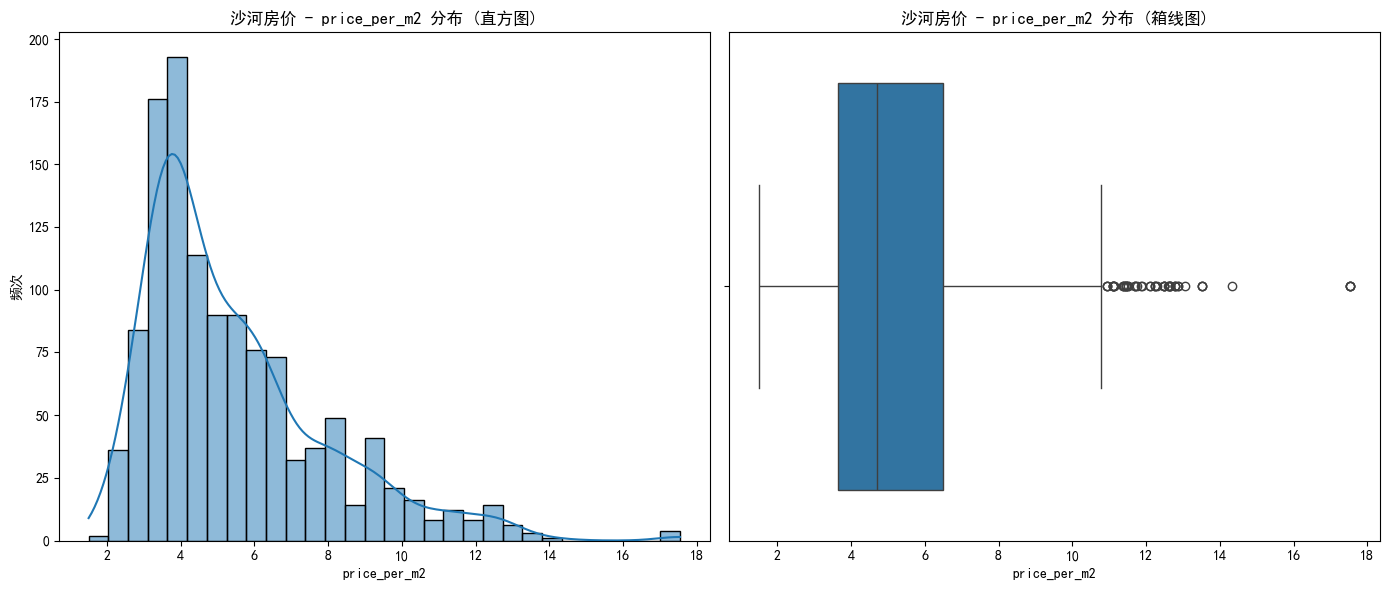

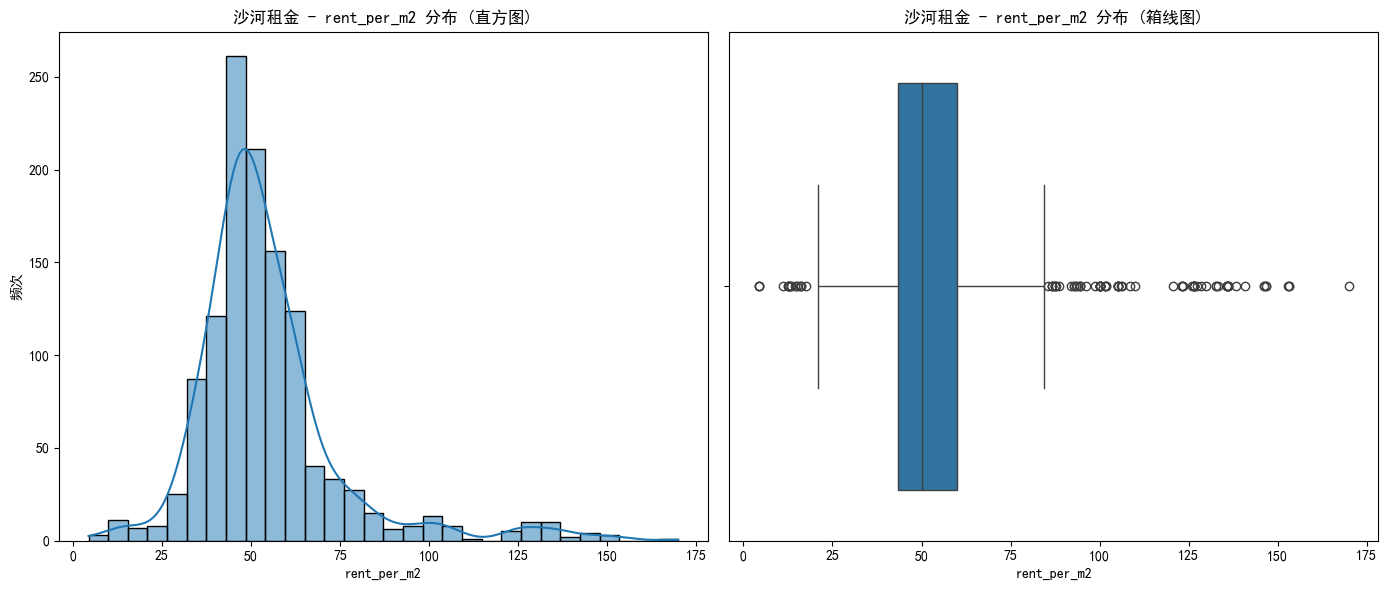

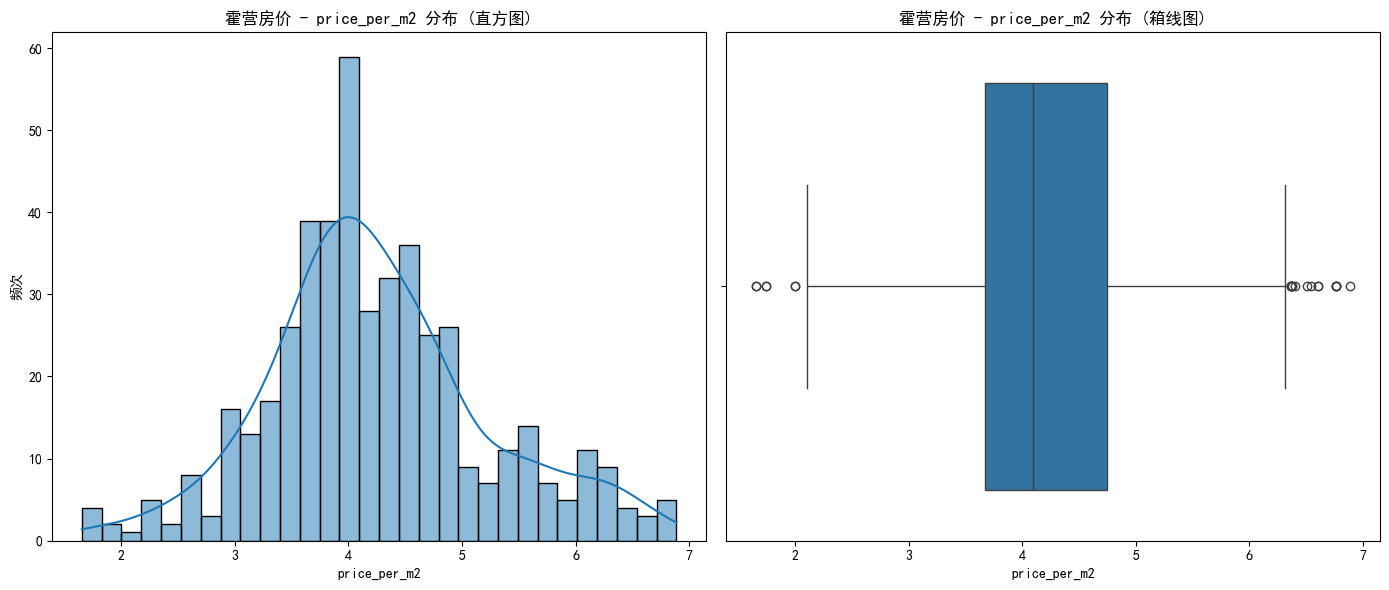

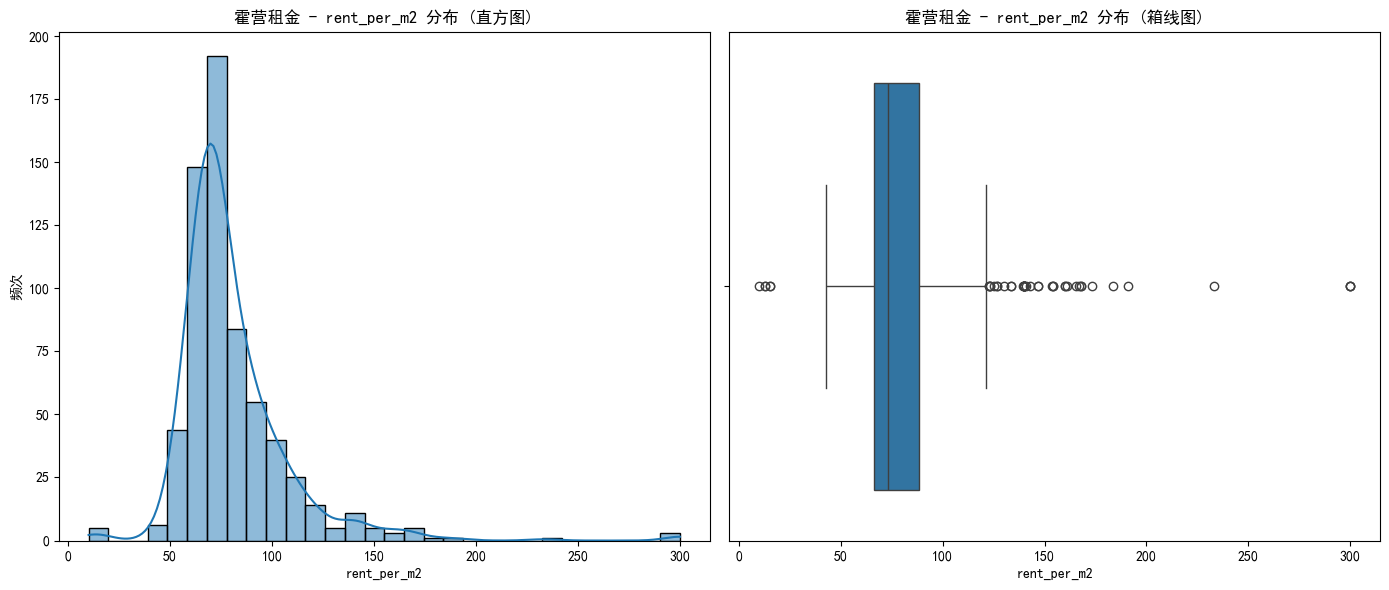

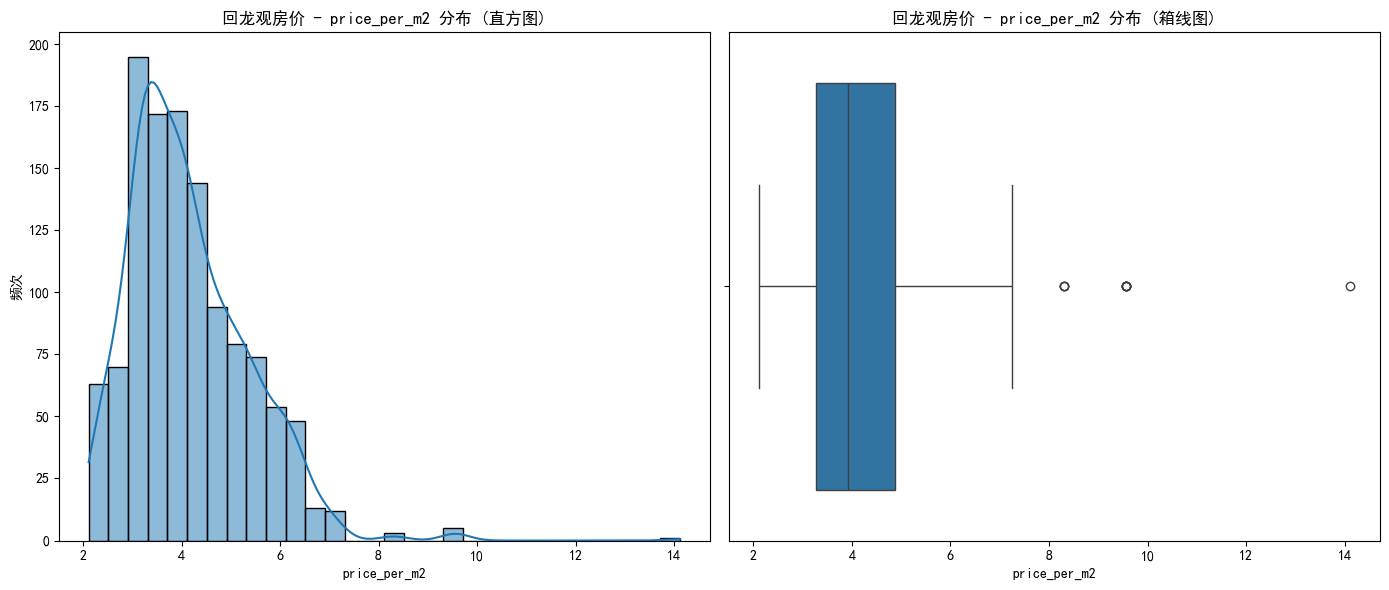

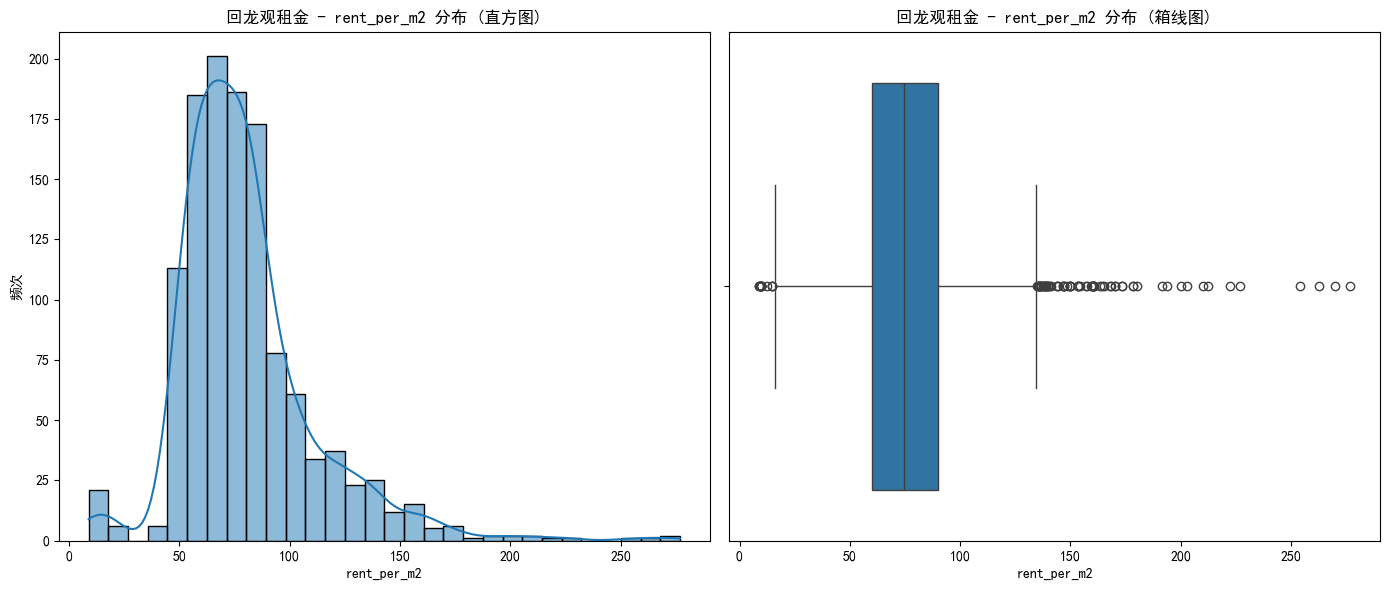

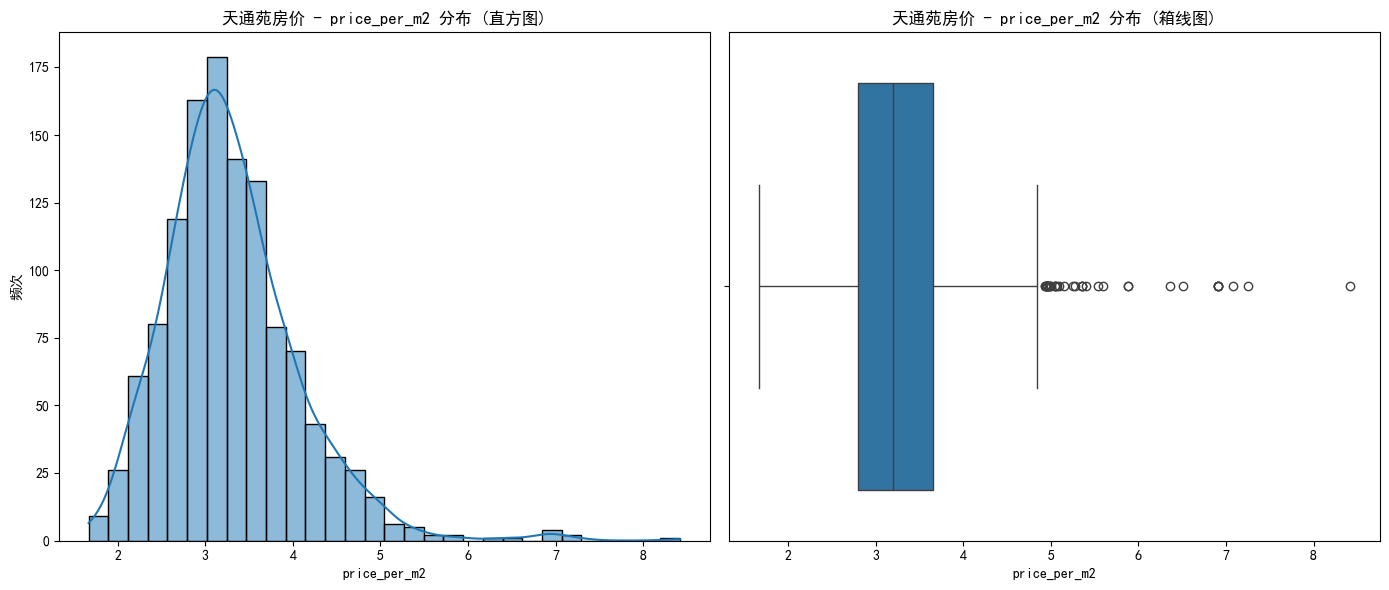

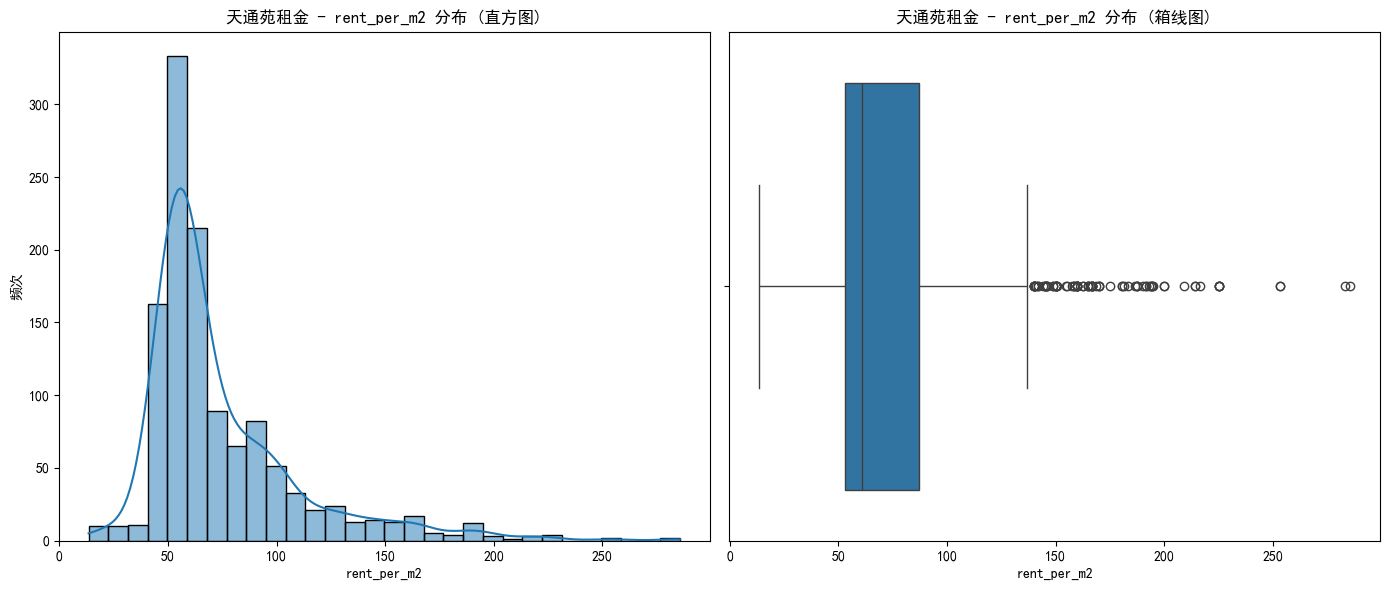


各区域房价租金比计算结果 
沙河房价租金比: 938.6
霍营房价租金比: 559.6
回龙观房价租金比: 523.6
天通苑房价租金比: 523.7


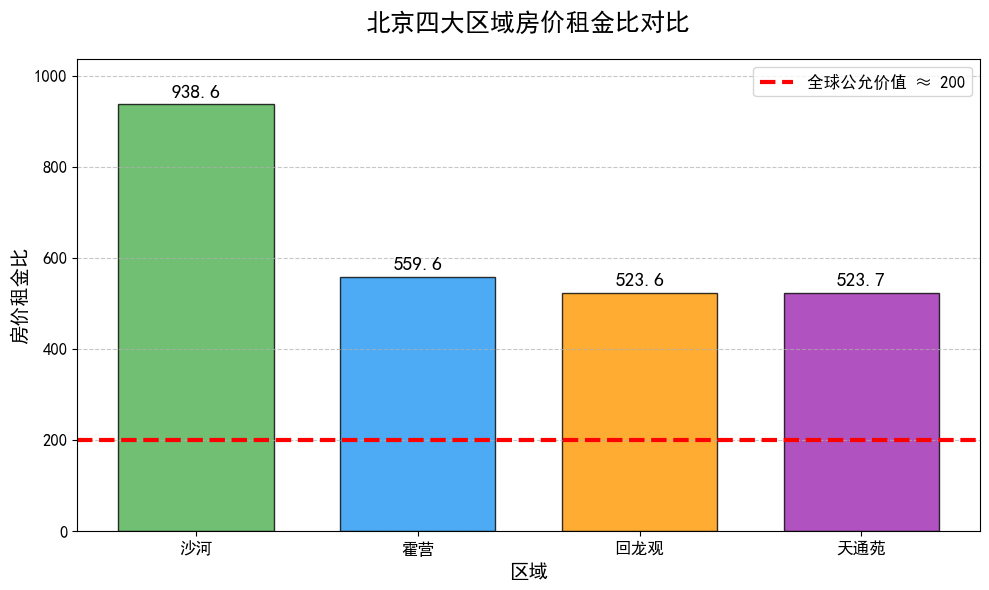

In [11]:


# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
rcParams['axes.unicode_minus'] = False    # 解决负号显示问题



# 读取数据 - 使用绝对路径
shahe_buy_df = pd.read_csv(r'H:\workspace\buy_shahe.csv')
shahe_rent_df = pd.read_csv(r'H:\workspace\rent_shahe.csv')
huoying_buy_df = pd.read_csv(r'H:\workspace\buy_huoying.csv')
huoying_rent_df = pd.read_csv(r'H:\workspace\rent_huoying.csv')
huilongguan_buy_df = pd.read_csv(r'H:\workspace\buy_huilongguan.csv')
huilongguan_rent_df = pd.read_csv(r'H:\workspace\rent_huilongguan.csv')
tiantongyuan_buy_df = pd.read_csv(r'H:\workspace\price_Tiantongyuan.csv')
tiantongyuan_rent_df = pd.read_csv(r'H:\workspace\rent_Tiantongyuan.csv')

# 计算每平方米价格/租金
def calculate_price_per_m2(df):
    df = df[df["面积"] > 0].copy()
    df.dropna(subset=["面积", "价格"], inplace=True)
    return df["价格"] / df["面积"]

shahe_buy_df["price_per_m2"] = calculate_price_per_m2(shahe_buy_df)
shahe_rent_df["rent_per_m2"] = calculate_price_per_m2(shahe_rent_df)
huoying_buy_df["price_per_m2"] = calculate_price_per_m2(huoying_buy_df)
huoying_rent_df["rent_per_m2"] = calculate_price_per_m2(huoying_rent_df)
huilongguan_buy_df["price_per_m2"] = calculate_price_per_m2(huilongguan_buy_df)
huilongguan_rent_df["rent_per_m2"] = calculate_price_per_m2(huilongguan_rent_df)
tiantongyuan_buy_df["price_per_m2"] = calculate_price_per_m2(tiantongyuan_buy_df)
tiantongyuan_rent_df["rent_per_m2"] = calculate_price_per_m2(tiantongyuan_rent_df)


# 异常值检测 - IQR 方法
def detect_outliers_iqr(df, col):
    """使用IQR方法检测异常值"""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_pct = len(outliers) / len(df) * 100
    print(f"{col} 异常值检测 (IQR方法):")
    print(f"下界: {lower_bound:.2f}, 上界: {upper_bound:.2f}")
    print(f"异常值数量: {len(outliers)} ({outlier_pct:.2f}%)\n")
    return outliers

# 检查每个数据集的异常值
detect_outliers_iqr(shahe_buy_df, "price_per_m2")
detect_outliers_iqr(shahe_rent_df, "rent_per_m2")
detect_outliers_iqr(huoying_buy_df, "price_per_m2")
detect_outliers_iqr(huoying_rent_df, "rent_per_m2")
detect_outliers_iqr(huilongguan_buy_df, "price_per_m2")
detect_outliers_iqr(huilongguan_rent_df, "rent_per_m2")
detect_outliers_iqr(tiantongyuan_buy_df, "price_per_m2")
detect_outliers_iqr(tiantongyuan_rent_df, "rent_per_m2")


#展示清理前的数据分布
def plot_distribution(df, name, col):
    """绘制数据的分布：直方图和箱线图"""
    plt.figure(figsize=(14, 6))
    
    # 直方图
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'{name} - {col} 分布 (直方图)')
    plt.xlabel(col)
    plt.ylabel('频次')
    
    # 箱线图
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'{name} - {col} 分布 (箱线图)')
    plt.xlabel(col)
    
    plt.tight_layout()
    plt.show()

# 绘制各区域的数据分布（仅清理前）
plot_distribution(shahe_buy_df, "沙河房价", "price_per_m2")
plot_distribution(shahe_rent_df, "沙河租金", "rent_per_m2")
plot_distribution(huoying_buy_df, "霍营房价", "price_per_m2")
plot_distribution(huoying_rent_df, "霍营租金", "rent_per_m2")
plot_distribution(huilongguan_buy_df, "回龙观房价", "price_per_m2")
plot_distribution(huilongguan_rent_df, "回龙观租金", "rent_per_m2")
plot_distribution(tiantongyuan_buy_df, "天通苑房价", "price_per_m2")
plot_distribution(tiantongyuan_rent_df, "天通苑租金", "rent_per_m2")


#对数据进行 Winsorize 清理

def winsorize_data(df, col, limits=(0.03, 0.03)):
    """使用Winsorize方法处理异常值"""
    df[col] = winsorize(df[col], limits=limits)  # 设置3%的上下界
    return df

# 进行Winsorize清理
shahe_buy_df = winsorize_data(shahe_buy_df, "price_per_m2")
shahe_rent_df = winsorize_data(shahe_rent_df, "rent_per_m2")
huoying_buy_df = winsorize_data(huoying_buy_df, "price_per_m2")
huoying_rent_df = winsorize_data(huoying_rent_df, "rent_per_m2")
huilongguan_buy_df = winsorize_data(huilongguan_buy_df, "price_per_m2")
huilongguan_rent_df = winsorize_data(huilongguan_rent_df, "rent_per_m2")
tiantongyuan_buy_df = winsorize_data(tiantongyuan_buy_df, "price_per_m2")
tiantongyuan_rent_df = winsorize_data(tiantongyuan_rent_df, "rent_per_m2")

# 计算房价租金比
def calculate_median_ratio(buy_df, rent_df):
    price_median = buy_df["price_per_m2"].median() * 10000  # 每平方米价格的中位数，乘以10000以便更直观
    rent_median = rent_df["rent_per_m2"].median()  # 每平方米租金的中位数
    return price_median / rent_median

shahe_ratio = calculate_median_ratio(shahe_buy_df, shahe_rent_df)
huoying_ratio = calculate_median_ratio(huoying_buy_df, huoying_rent_df)
huilongguan_ratio = calculate_median_ratio(huilongguan_buy_df, huilongguan_rent_df)
tiantongyuan_ratio = calculate_median_ratio(tiantongyuan_buy_df, tiantongyuan_rent_df)


print("\n各区域房价租金比计算结果 ")
print(f"沙河房价租金比: {shahe_ratio:.1f}")
print(f"霍营房价租金比: {huoying_ratio:.1f}")
print(f"回龙观房价租金比: {huilongguan_ratio:.1f}")
print(f"天通苑房价租金比: {tiantongyuan_ratio:.1f}")

# 绘制四个区域的中位数对比柱状图
plt.figure(figsize=(10, 6))
regions = ["沙河", "霍营", "回龙观", "天通苑"]
ratios = [shahe_ratio, huoying_ratio, huilongguan_ratio, tiantongyuan_ratio]
colors = ["#4CAF50", "#2196F3", "#FF9800", "#9C27B0"]

bars = plt.bar(regions, ratios, color=colors, edgecolor="black", width=0.7, alpha=0.8)
for bar, ratio in zip(bars, ratios):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{ratio:.1f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.axhline(y=200, color='red', linestyle='--', linewidth=3, label='全球公允价值 ≈ 200')
plt.title("北京四大区域房价租金比对比", fontsize=18, pad=20, fontweight='bold')
plt.xlabel("区域", fontsize=14)
plt.ylabel("房价租金比", fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.ylim(0, max(ratios) + 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


3.4任务

线性回归模型统计数据

🏠 房价预测模型统计:
训练集样本数: 640
测试集样本数: 160
特征数量: 4
R²分数 (训练集): 0.3770
R²分数 (测试集): 0.3804
截距项: 3.42

特征系数:
                      特征        系数
3  location_tiangongyuan -0.741216
2         location_shahe  0.532845
1       location_huoying  0.354647
0                     面积  0.004364

 租金预测模型统计:
训练集样本数: 640
测试集样本数: 160
特征数量: 4
R²分数 (训练集): 0.1796
R²分数 (测试集): 0.1081
截距项: 79.93

特征系数:
                      特征         系数
2         location_shahe -24.080705
3  location_tiangongyuan  -4.214810
1       location_huoying  -1.090728
0                     面积  -0.016545

各区块预测结果:
              median_price_per_m2  median_rent_per_m2  price_rent_ratio
location                                                               
huilongguan                  3.87               78.49            492.83
huoying                      4.16               77.63            536.06
shahe                        5.11               54.47            938.37
tiangongyuan                 3.26               74.23           

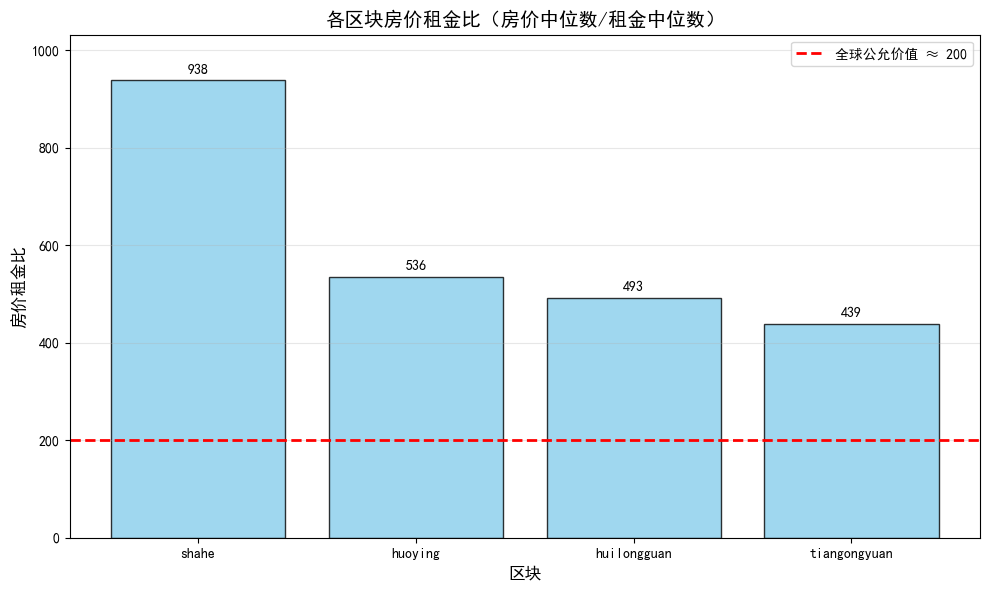

In [12]:

shahe_buy_file = r"H:\workspace\buy_shahe.csv"
shahe_rent_file = r"H:\workspace\rent_shahe.csv"
huoying_buy_file = r"H:\workspace\buy_huoying.csv"
huoying_rent_file = r"H:\workspace/rent_huoying.csv"
huilongguan_buy_file = r"H:\workspace\buy_huilongguan.csv"
huilongguan_rent_file = r"H:\workspace/rent_huilongguan.csv"
tiantongyuan_buy_file = r"H:\workspace\price_Tiantongyuan.csv"
tiantongyuan_rent_file = r"H:\workspace/rent_Tiantongyuan.csv"


# 2添加 location 列
def add_location_column(df, filename):
    basename = os.path.basename(filename).lower()
    if 'shahe' in basename:
        location = 'shahe'
    elif 'huoying' in basename:
        location = 'huoying'
    elif 'huilongguan' in basename:
        location = 'huilongguan'
    elif 'tiantongyuan' in basename:
        location = 'tiangongyuan'
    else:
        location = 'unknown'
    
    df['location'] = location
    return df
def check_and_create_columns(df, is_buy=True):
    area_col = None
    price_col = None
    
    for col in df.columns:
        if '面积' in col or '平米' in col or '平方' in col:
            area_col = col
        if '价格' in col or '价' in col or '总价' in col:
            price_col = col
    
    if area_col is None or price_col is None:
        return df
    
    if is_buy:
        sample_price = df[price_col].iloc[0] if len(df) > 0 else 0
        if sample_price > 1000000:
            df['price_per_m2'] = df[price_col] / df[area_col] / 10000
        else:
            df['price_per_m2'] = df[price_col] / df[area_col]
    else:
        df['rent_per_m2'] = df[price_col] / df[area_col]
    
    return df

# 为每个DataFrame添加 location 列
shahe_buy_df = add_location_column(shahe_buy_df, shahe_buy_file)
shahe_rent_df = add_location_column(shahe_rent_df, shahe_rent_file)
huoying_buy_df = add_location_column(huoying_buy_df, huoying_buy_file)
huoying_rent_df = add_location_column(huoying_rent_df, huoying_rent_file)
huilongguan_buy_df = add_location_column(huilongguan_buy_df, huilongguan_buy_file)
huilongguan_rent_df = add_location_column(huilongguan_rent_df, huilongguan_rent_file)
tiantongyuan_buy_df = add_location_column(tiantongyuan_buy_df, tiantongyuan_buy_file)
tiantongyuan_rent_df = add_location_column(tiantongyuan_rent_df, tiantongyuan_rent_file)


# 处理数据
shahe_buy_df = check_and_create_columns(shahe_buy_df, is_buy=True)
shahe_rent_df = check_and_create_columns(shahe_rent_df, is_buy=False)
huoying_buy_df = check_and_create_columns(huoying_buy_df, is_buy=True)
huoying_rent_df = check_and_create_columns(huoying_rent_df, is_buy=False)
huilongguan_buy_df = check_and_create_columns(huilongguan_buy_df, is_buy=True)
huilongguan_rent_df = check_and_create_columns(huilongguan_rent_df, is_buy=False)
tiantongyuan_buy_df = check_and_create_columns(tiantongyuan_buy_df, is_buy=True)
tiantongyuan_rent_df = check_and_create_columns(tiantongyuan_rent_df, is_buy=False)


buy_dfs = [shahe_buy_df, huoying_buy_df, huilongguan_buy_df, tiantongyuan_buy_df]
rent_dfs = [shahe_rent_df, huoying_rent_df, huilongguan_rent_df, tiantongyuan_rent_df]

for i, df in enumerate(buy_dfs):
    buy_dfs[i] = winsorize_data(df, "price_per_m2")

for i, df in enumerate(rent_dfs):
    rent_dfs[i] = winsorize_data(df, "rent_per_m2")

#数据准备

buy_df = pd.concat([df for df in buy_dfs if df is not None and len(df) > 0])
rent_df = pd.concat([df for df in rent_dfs if df is not None and len(df) > 0])

buy_df = buy_df[["面积", "location", "price_per_m2"]].copy()
rent_df = rent_df[["面积", "location", "rent_per_m2"]].copy()

# 加权取样
def weighted_sample(df, n_samples=800):
    if len(df) <= n_samples:
        return df
    location_counts = df['location'].value_counts(normalize=True)
    samples_per_location = (location_counts * n_samples).round().astype(int)
    total = samples_per_location.sum()
    if total > n_samples:
        samples_per_location[samples_per_location.idxmax()] -= (total - n_samples)
    elif total < n_samples:
        samples_per_location[samples_per_location.idxmax()] += (n_samples - total)
    
    sampled_dfs = []
    for loc, count in samples_per_location.items():
        loc_df = df[df['location'] == loc]
        sampled = loc_df.sample(min(count, len(loc_df)), random_state=42)
        sampled_dfs.append(sampled)
    
    return pd.concat(sampled_dfs, ignore_index=True)

buy_df_sample = weighted_sample(buy_df, n_samples=800)
rent_df_sample = weighted_sample(rent_df, n_samples=800)
# 线性回归模型
# 房价预测模型
buy_df_encoded = pd.get_dummies(buy_df_sample, columns=["location"], drop_first=True)
X_buy = buy_df_encoded[["面积"] + [col for col in buy_df_encoded.columns if col.startswith("location_")]]
y_buy = buy_df_encoded["price_per_m2"]
X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X_buy, y_buy, test_size=0.2, random_state=42)
model_buy = LinearRegression()
model_buy.fit(X_train_buy, y_train_buy)

# 租金预测模型
rent_df_encoded = pd.get_dummies(rent_df_sample, columns=["location"], drop_first=True)
X_rent = rent_df_encoded[["面积"] + [col for col in rent_df_encoded.columns if col.startswith("location_")]]
y_rent = rent_df_encoded["rent_per_m2"]
X_train_rent, X_test_rent, y_train_rent, y_test_rent = train_test_split(X_rent, y_rent, test_size=0.2, random_state=42)
model_rent = LinearRegression()
model_rent.fit(X_train_rent, y_train_rent)


# 预测模型统计数据
print("线性回归模型统计数据")
# 房价模型统计
print("\n🏠 房价预测模型统计:")
print(f"训练集样本数: {len(X_train_buy)}")
print(f"测试集样本数: {len(X_test_buy)}")
print(f"特征数量: {len(X_buy.columns)}")
print(f"R²分数 (训练集): {model_buy.score(X_train_buy, y_train_buy):.4f}")
print(f"R²分数 (测试集): {model_buy.score(X_test_buy, y_test_buy):.4f}")
print(f"截距项: {model_buy.intercept_:.2f}")

print("\n特征系数:")
feature_coef_buy = pd.DataFrame({
    '特征': X_buy.columns,
    '系数': model_buy.coef_
}).sort_values('系数', key=abs, ascending=False)
print(feature_coef_buy)

# 租金模型统计
print("\n 租金预测模型统计:")
print(f"训练集样本数: {len(X_train_rent)}")
print(f"测试集样本数: {len(X_test_rent)}")
print(f"特征数量: {len(X_rent.columns)}")
print(f"R²分数 (训练集): {model_rent.score(X_train_rent, y_train_rent):.4f}")
print(f"R²分数 (测试集): {model_rent.score(X_test_rent, y_test_rent):.4f}")
print(f"截距项: {model_rent.intercept_:.2f}")

print("\n特征系数:")
feature_coef_rent = pd.DataFrame({
    '特征': X_rent.columns,
    '系数': model_rent.coef_
}).sort_values('系数', key=abs, ascending=False)
print(feature_coef_rent)
# ==============================
# 8. 生成房价租金比柱状图
# ==============================
import matplotlib.pyplot as plt

# 预测所有数据
buy_df_encoded = pd.get_dummies(buy_df, columns=["location"], drop_first=True)
X_buy_full = buy_df_encoded[["面积"] + [col for col in buy_df_encoded.columns if col.startswith("location_")]]
buy_df["predicted_price_per_m2"] = model_buy.predict(X_buy_full)

rent_df_encoded = pd.get_dummies(rent_df, columns=["location"], drop_first=True)
X_rent_full = rent_df_encoded[["面积"] + [col for col in rent_df_encoded.columns if col.startswith("location_")]]
rent_df["predicted_rent_per_m2"] = model_rent.predict(X_rent_full)

# 计算各区块中位数和房价租金比
price_median = buy_df.groupby("location")["predicted_price_per_m2"].median()
rent_median = rent_df.groupby("location")["predicted_rent_per_m2"].median()

results_df = pd.DataFrame({
    'median_price_per_m2': price_median,
    'median_rent_per_m2': rent_median
})
results_df['price_rent_ratio'] = (results_df['median_price_per_m2'] * 10000) / results_df['median_rent_per_m2']

print("\n各区块预测结果:")
print(results_df.round(2))


# 生成房价租金比柱状图

plt.figure(figsize=(10, 6))
# 按房价租金比排序
results_sorted = results_df.sort_values('price_rent_ratio', ascending=False)
locations = results_sorted.index

# 创建柱状图
bars = plt.bar(locations, results_sorted['price_rent_ratio'], 
               color='skyblue', alpha=0.8, edgecolor='black')
plt.axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球公允价值 ≈ 200')
plt.title('各区块房价租金比（房价中位数/租金中位数）', fontsize=14, fontweight='bold')
plt.xlabel('区块', fontsize=12)
plt.ylabel('房价租金比', fontsize=12)
plt.legend()
max_ratio = max(results_sorted['price_rent_ratio'].max(), 200)
plt.ylim(0, max_ratio * 1.1)
for bar, ratio in zip(bars, results_sorted['price_rent_ratio']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max_ratio * 0.01,
             f'{ratio:.0f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



3.5任务

In [ ]:

#模型增强：添加非线性特征和交互项

# 增强房价预测模型 (模型1+)
buy_df_encoded['面积平方'] = buy_df_encoded['面积'] ** 2
buy_df_encoded['面积_log'] = np.log(buy_df_encoded['面积'] + 1)
buy_df_encoded['面积_交互'] = buy_df_encoded['面积'] * buy_df_encoded['location_huoying']

X_buy_plus = buy_df_encoded[["面积", "面积平方", "面积_log", "面积_交互"] + 
                           [col for col in buy_df_encoded.columns if col.startswith("location_")]]
y_buy_plus = buy_df_encoded["price_per_m2"]
X_train_buy_plus, X_test_buy_plus, y_train_buy_plus, y_test_buy_plus = train_test_split(
    X_buy_plus, y_buy_plus, test_size=0.2, random_state=42)
model_buy_plus = LinearRegression()
model_buy_plus.fit(X_train_buy_plus, y_train_buy_plus)

# 增强租金预测模型 (模型2+)
rent_df_encoded['面积平方'] = rent_df_encoded['面积'] ** 2
rent_df_encoded['面积_log'] = np.log(rent_df_encoded['面积'] + 1)
rent_df_encoded['面积_交互'] = rent_df_encoded['面积'] * rent_df_encoded['location_huoying']

X_rent_plus = rent_df_encoded[["面积", "面积平方", "面积_log", "面积_交互"] + 
                             [col for col in rent_df_encoded.columns if col.startswith("location_")]]
y_rent_plus = rent_df_encoded["rent_per_m2"]
X_train_rent_plus, X_test_rent_plus, y_train_rent_plus, y_test_rent_plus = train_test_split(
    X_rent_plus, y_rent_plus, test_size=0.2, random_state=42)
model_rent_plus = LinearRegression()
model_rent_plus.fit(X_train_rent_plus, y_train_rent_plus)


# 比较模型R²分数


print("\n房价预测模型比较:")
print(f"模型1 (基础模型) R²分数 (训练集): {model_buy.score(X_train_buy, y_train_buy):.4f}")
print(f"模型1 (基础模型) R²分数 (测试集): {model_buy.score(X_test_buy, y_test_buy):.4f}")
print(f"模型1+ (增强模型) R²分数 (训练集): {model_buy_plus.score(X_train_buy_plus, y_train_buy_plus):.4f}")
print(f"模型1+ (增强模型) R²分数 (测试集): {model_buy_plus.score(X_test_buy_plus, y_test_buy_plus):.4f}")

print("\n 租金预测模型比较:")
print(f"模型2 (基础模型) R²分数 (训练集): {model_rent.score(X_train_rent, y_train_rent):.4f}")
print(f"模型2 (基础模型) R²分数 (测试集): {model_rent.score(X_test_rent, y_test_rent):.4f}")
print(f"模型2+ (增强模型) R²分数 (训练集): {model_rent_plus.score(X_train_rent_plus, y_train_rent_plus):.4f}")
print(f"模型2+ (增强模型) R²分数 (测试集): {model_rent_plus.score(X_test_rent_plus, y_test_rent_plus):.4f}")


#使用增强模型预测所有数据并计算房价租金比


buy_df["predicted_price_per_m2_plus"] = model_buy_plus.predict(X_buy_plus)
rent_df["predicted_rent_per_m2_plus"] = model_rent_plus.predict(X_rent_plus)

# 计算各区块中位数和房价租金比
price_median_plus = buy_df.groupby("location")["predicted_price_per_m2_plus"].median()
rent_median_plus = rent_df.groupby("location")["predicted_rent_per_m2_plus"].median()

results_df_plus = pd.DataFrame({
    'median_price_per_m2_plus': price_median_plus,
    'median_rent_per_m2_plus': rent_median_plus
})
results_df_plus['price_rent_ratio_plus'] = (results_df_plus['median_price_per_m2_plus'] * 10000) / results_df_plus['median_rent_per_m2_plus']

# 合并基础模型和增强模型的结果
final_results = pd.concat([results_df, results_df_plus], axis=1)
print("\n各区块预测结果比较:")
print(final_results.round(2))


#绘制增强模型的房价租金比条形图 (图表C)

plt.figure(figsize=(10, 6))
results_sorted_plus = results_df_plus.sort_values('price_rent_ratio_plus', ascending=False)
locations_plus = results_sorted_plus.index

# 创建柱状图
bars = plt.bar(locations_plus, results_sorted_plus['price_rent_ratio_plus'], 
               color='lightgreen', alpha=0.8, edgecolor='black')
plt.axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球公允价值 ≈ 200')
plt.title('各区块房价租金比（增强模型预测）', fontsize=14, fontweight='bold')
plt.xlabel('区块', fontsize=12)
plt.ylabel('房价租金比', fontsize=12)
plt.legend()
max_ratio_plus = max(results_sorted_plus['price_rent_ratio_plus'].max(), 200)
plt.ylim(0, max_ratio_plus * 1.1)
for bar, ratio in zip(bars, results_sorted_plus['price_rent_ratio_plus']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max_ratio_plus * 0.01,
             f'{ratio:.0f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



结论：

对于房价预测模型，基础模型表现较好，尤其在测试集上的 R² 高于增强模型的测试集表现。增强模型可能存在过拟合问题，因此 更信任基础模型。

对于租金预测模型，增强模型（模型2+）表现明显优于基础模型（模型2），特别是在测试集上，R² 远远高于基础模型。由于增强模型有较强的泛化能力，因此 可以更信任增强模型（模型2+）。

房价预测模型：基础模型的泛化能力更强，因此在样本量较大时，更应该信任 基础模型 的结果。

租金预测模型：增强模型的表现非常好，尤其在测试集上的高 R² 表明它能够更准确地捕捉租金数据的规律，因此在这种情况下 增强模型 更值得信任。

总结来说，房价预测 推荐信任基础模型，而 租金预测 推荐信任增强模型。